In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/MyDrive/NLP ML/'

#Data Preparation

Total number of Comments: 2002


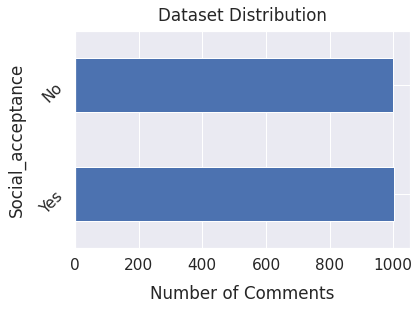

In [ ]:
# data = pd.read_csv('https://raw.githubusercontent.com/mdforhadcse/Bangla_Comments_Dataset/main/Final.csv',encoding='utf-8')
data = pd.read_csv('https://raw.githubusercontent.com/mdforhadcse/Bangla_Comments_Dataset/main/2000data.csv',encoding='UTF-8')
print(f'Total number of Comments: {len(data)}')
sns.set(font_scale=1.4)
data['Social_acceptance'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Social_acceptance", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
data.columns

Index(['No.', 'Social_acceptance', 'Comment'], dtype='object')

#Data Cleaning

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      Comments = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return Comments
# Apply the function into the dataframe
data['cleaned'] = data['Comment'].apply(cleaning_data)  

# print some cleaned reviews from the dataset
sample_data = [10,100,150,200,250,600,650,666,689,640,650,700,750,800,1000]
for i in sample_data:
  print('Original: ',data.Comment[i],'\nCleaned:',
           data.cleaned[i],'\n','Socialacceptance:-- ',data.Social_acceptance[i],'\n')   

Original:  জ্বী ভাই।আপনাগো তালতো কি রুমে হিজরা নিয়ে গেসিলো?? সেটা কেনো এতো তড়ি ঘড়ি করে ছাপেন না।হেফাজত কে এতোদিন চাটছেন আপনাদের প্রশাসন। এখন হেফাজত দুর্গন্ধ ময় হয়ে গেলো।মাইয়া বাজ হয়ে গেলো! ফালতু পত্রিকা একটা। 
Cleaned: জ্বী ভাই আপনাগো তালতো কি রুমে হিজরা নিয়ে গেসিলো   সেটা কেনো এতো তড়ি ঘড়ি করে ছাপেন না হেফাজত কে এতোদিন চাটছেন আপনাদের প্রশাসন  এখন হেফাজত দুর্গন্ধ ময় হয়ে গেলো মাইয়া বাজ হয়ে গেলো  ফালতু পত্রিকা একটা  
 Socialacceptance:--  No 

Original:  পাবলিক বিশব্বিদ্যালয় গুলো অযোগ্যদের দখলে এখন! 
Cleaned: পাবলিক বিশব্বিদ্যালয় গুলো অযোগ্যদের দখলে এখন  
 Socialacceptance:--  No 

Original:  সাহস সাফল্যের চাবি কাঠি 
Cleaned: সাহস সাফল্যের চাবি কাঠি 
 Socialacceptance:--  No 

Original:  লেন্ডি 
Cleaned: লেন্ডি 
 Socialacceptance:--  No 

Original:  শালির ঘরের শালি 
Cleaned: শালির ঘরের শালি 
 Socialacceptance:--  No 

Original:  বুরি হলে বুঝবি তুই এখন নয় । 
Cleaned: বুরি হলে বুঝবি তুই এখন নয়   
 Socialacceptance:--  No 

Original:  ভালো হয়ে যাও নোবেল!! 
Cleaned: ভালো হয়ে যাও নোবেল   
 Soc

#Remove Low Length Data

In [ ]:
# Length of each Comments
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the Comments with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Comments".format(len(data)-len(dataset)),
      "\nTotal Comments:",len(dataset))

After Cleaning: 
Removed 203 Small Comments 
Total Comments: 1799


#Dataset Analysis

In [ ]:
def data_summary(dataset):
    
    """
    This function will print the summary of the Comments and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Social_acceptance.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Social_acceptance==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Social_acceptance==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Social_acceptance==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)    



Class Name :  Yes
Number of Documents:914
Number of Words:18433
Number of Unique Words:5320
Most Frequent Words:

না	260
আপনার	182
করে	181
এই	170
ও	132
আমার	119
আর	116
আমাদের	114
কি	113
জন্য	113

Class Name :  No
Number of Documents:885
Number of Words:10370
Number of Unique Words:4089
Most Frequent Words:

না	213
করে	102
এই	90
কি	88
আর	81
ভাই	63
তো	62
একটা	58
তোমার	58
ভালো	56
Total Number of Unique Words:7867


#Summary Visualization

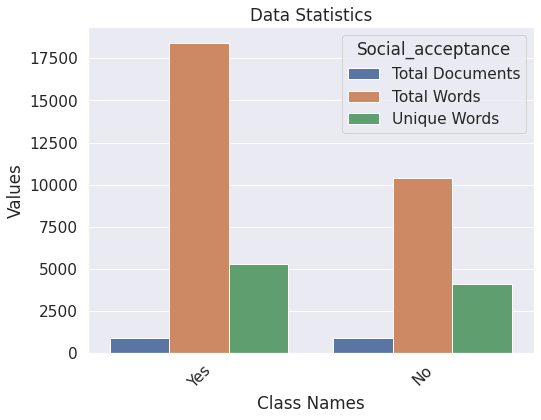

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Social_acceptance", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Social_acceptance')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

#Comment Length Distribution

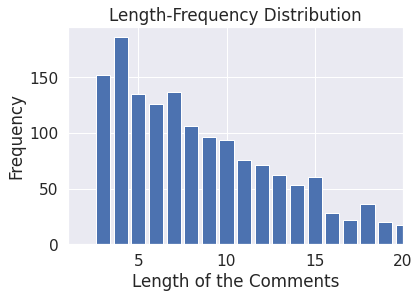

Maximum Length of a Comment: 542
Minimum Length of a Comment: 3
Average Length of a Comment: 16.0


In [ ]:
# Calculate the Review of each of the Review
dataset['CommentLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.CommentLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Comments')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Comment: {max(dataset.CommentLength)}")
print(f"Minimum Length of a Comment: {min(dataset.CommentLength)}")
print(f"Average Length of a Comment: {round(np.mean(dataset.CommentLength),0)}")

#Lable Encoding and Dataset Splitting

In [ ]:
# accepted = dataset[dataset.Social_acceptance == "Yes"]                  
# not_accepted = dataset[dataset.Social_acceptance == "No"]
# dataset = accepted.append(not_accepted,ignore_index=True)
# dataset.Social_acceptance.value_counts()

In [ ]:
dataset['Social_acceptance'] = dataset['Social_acceptance'].astype(str)

In [ ]:
dataset

,No.,Social_acceptance,Comment,cleaned,length,CommentLength
0,1,No,আবাল মার্কা সাংঘাতিক,আবাল মার্কা সাংঘাতিক,3,3
1,4,No,রেজিস্ট্রার একটা বলদের আতুরি।,রেজিস্ট্রার একটা বলদের আতুরি,4,4
2,5,No,"প্রতিবন্ধী কোটার রেজিস্ট্রার, মাইন্ড তো করবেই।",প্রতিবন্ধী কোটার রেজিস্ট্রার মাইন্ড তো করবেই,6,6
3,6,No,উনি কি বুকাসুদা,উনি কি বুকাসুদা,3,3
4,7,No,তুই শুধু ছাগল নাছাগলদের নেতা- ভানু,তুই শুধু ছাগল নাছাগলদের নেতা ভানু,6,6
...,...,...,...,...,...,...
1794,3996,Yes,স্যার ইসলামি অর্থনীতি ব্যবস্থা সব কিছুর ভারসাম...,স্যার ইসলামি অর্থনীতি ব্যবস্থা সব কিছুর ভারসাম...,13,13
1795,3998,Yes,অন্যায়ভাবে ভালো থাকা,অন্যায়ভাবে ভালো থাকা,3,3
1796,3999,Yes,বিত্তবানদের তো শুধু চাই আর চাই। চাবেই না বা কে...,বিত্তবানদের তো শুধু চাই আর চাই চাবেই না বা কে...,55,55
1797,4000,Yes,অসাধারণ লেখা ভাই সাব।,অসাধারণ লেখা ভাই সাব,4,4


In [ ]:
data.isnull().count()

No.                  2002
Social_acceptance    2002
Comment              2002
cleaned              2002
length               2002
dtype: int64

In [ ]:
                                      #==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(Social_acceptance,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        Social_acceptance: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(Social_acceptance)
    encoded_labels = le.transform(Social_acceptance)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
          print(Social_acceptance[i],' ', encoded_labels[i],'\n')

    return labels




In [ ]:
labels = label_encoding(dataset.Social_acceptance,True)


			===== Label Encoding ===== 
Class Names:--> ['No' 'Yes']
No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

No   0 

Yes   1 



In [ ]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:

                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(Comments,Social_acceptance):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        Comments: sequenced Comments 
        Social_acceptance: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X,X_test,y,y_test = train_test_split(Comments,Social_acceptance,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(Comments),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test


In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.Comment,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1799 
	Training		 1295 
	Test			 180 
	Validation		 324


#Tokenization

In [ ]:
vocab_size = 50000
embedding_dim = 1024
max_length = 542
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def padded_Comments(original,encoded,padded):
  '''
  print the samples padded Comments
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(original,"\n",encoded) 
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)  

In [ ]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


In [ ]:
 #============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
না 	 277
করে 	 195
এই 	 181
কি 	 160
আপনার 	 156
আর 	 142
ও 	 122
ভাই 	 117
আমার 	 115
আমি 	 110

Words --> Documents:
না 	 202
কি 	 129
করে 	 128
আপনার 	 127
এই 	 123
আর 	 119
ভাই 	 89
ও 	 88
আমার 	 85
আমি 	 83

Words --> Index:
দ্বারা 	 6874
ট্রলার। 	 6873
সবগোলাই 	 6872
।এখন 	 6871
ফলোয়ার 	 6870
প্রথমে 	 6869
স্বচ্ছ 	 6868
চাইলেই 	 6867
আরেকজন 	 6866
ওয়াস্তে 	 6865

Total Documents --> 1295
Found 6874 unique tokens


In [ ]:
padded_Comments(X_train,train_sequences[10],train_padded[10]) 


			====== Encoded Sequences ====== 

904                                 এ জ্বালা রাখি কোথায়.?
701     কিরে ভাই আমি তো তোমার ডিভোর্স করাইনি এমন ভাব ন...
646     ম্যাকাপ ছাড়া একটা পিক আপলোড কর বোইন!তার পর দেখ...
999     আপনার পাশে লোকজন যে ভাবে ভিড় করছে মনে হয় না বা...
1074    জনগণের ভোটাধিকার প্রয়োগ করার সুযোগ দিন। যেই দ...
                              ...                        
1079    এতো বড় ঋষির রাতের ভোটে এম্পি হতে হয়ে।কি আপচুস,...
1069    এসব মোটিভেশন মার্কা কথা আপনার মুখে মানায় না। ...
1410                         আমরা করনার চাইতেও শক্তিশালী।
1388    প্রথমে ভাবছিলাম এত ফলোয়ার ।এখন দেখছি সবগোলাই ট...
613                                আপনার দ্বারা সবই সম্ভব
Name: Comment, Length: 1295, dtype: object 
 [2462, 2463, 1025, 1450, 119]

			====== Paded Sequences ======
 904                                 এ জ্বালা রাখি কোথায়.?
701     কিরে ভাই আমি তো তোমার ডিভোর্স করাইনি এমন ভাব ন...
646     ম্যাকাপ ছাড়া একটা পিক আপলোড কর বোইন!তার পর দেখ...
999     আপনার পাশে লোকজন যে ভাবে ভিড় করছ

In [ ]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
padded_Comments(X_valid,validation_sequences[1],validation_padded[1]) 



			====== Encoded Sequences ====== 

944     সচেতনার অভাবে আমরা বড় কোন দুর্ঘটনার অংশ হয়ে যে...
1279           আল্লাহ আপনাকে আরো ভাল কাজে এগিয়ে নিয়ে যাক।
951     ১৬৭ টি সেদ্ধ ডিমের দাম ১৬৭*১০= ১৬৭০৳।সরকারের অ...
561     আগে জানতাম ও দেখতাম মেয়েরা কমপিটিশন দিয়া ছেলেদ...
1052                        উফফ,,,,,দীপু আপার হাসিটা!!!!!
                              ...                        
914                                       বাল ফেলে দিয়েছে
1528                         তারেক ভাইয়ের জন্য দোয়া রয়েছে
645                                 সেলিবেটি অকলের খাইছলত
70      ধীমান ঘোষ নিজেও ছাত্রলীগ।অকারণে ধর্মের নাম টেন...
728     হেলেনা জাহাংগীর আপনি বেনজির এবং হাসিনাকে তেল ম...
Name: Comment, Length: 324, dtype: object 
 [82, 40, 133, 158, 432, 258, 41, 1]

			====== Paded Sequences ======
 944     সচেতনার অভাবে আমরা বড় কোন দুর্ঘটনার অংশ হয়ে যে...
1279           আল্লাহ আপনাকে আরো ভাল কাজে এগিয়ে নিয়ে যাক।
951     ১৬৭ টি সেদ্ধ ডিমের দাম ১৬৭*১০= ১৬৭০৳।সরকারের অ...
561     আগে জানতাম ও দেখতাম মেয়েরা 

In [ ]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_Comments(X_test,test_sequences[100],test_padded[100]) 


			====== Encoded Sequences ====== 

597      মূর্খরা সবসময় নেতিবাচক কমেন্ট করে এটাই স্বাভাবিক
831     যত টেকনিক আছে ব্যাবহার কর কিন্তু হা হা রিয়েক্ট...
1174    ফাবি আইয়ি আলা ই রাব্বিকুম মাতু কাজ্জীবান অর্থ ...
467     ক্যেমরা ম্যান তোমার পসংসা না করে পারলাম না তুম...
1721    বাংলাদেশীদের মধ্যে এর প্রবনতা অনেক বেশি,যেটা খ...
                              ...                        
1730    সবাই যদি আপনার মতো এসির নিজে বসে অফিস করতো তাহ...
853     তুমিও মজা পাইছ,,আমিও মজা পাইছি,, আপাতত নিরব থাকো।
1188    সুবহানাল্লাহ অসাধারণ একটা অায়াত নিয়ে পোস্ট দেও...
1238    ভাই বর্তমান সময়ে একজন জনপ্রিয় আলেম আবু ত্বহা...
1593                            নাটোর নলডাঙ্গা পৌর বিএনপি
Name: Comment, Length: 180, dtype: object 
 [433, 4055, 717, 1, 631, 132, 1218, 1, 316, 80, 1, 1599, 428]

			====== Paded Sequences ======
 597      মূর্খরা সবসময় নেতিবাচক কমেন্ট করে এটাই স্বাভাবিক
831     যত টেকনিক আছে ব্যাবহার কর কিন্তু হা হা রিয়েক্ট...
1174    ফাবি আইয়ি আলা ই রাব্বিকুম মাতু কাজ্জীবান অর্থ ...
467     ক

In [ ]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.Social_acceptance)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

#Model Defination

In [ ]:
keras.backend.clear_session()
accuracy_threshold = 0.97
vocab_size = 57000
embedding_dim = 64
max_length = 21
num_Social_acceptance = 6

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint] 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64,dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_Social_acceptance, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            3648000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49920     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 3,701,166
Trainable params: 3,701,166
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 15
batch = 30
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/15
44/44 [==============================] - 19s 231ms/step - loss: 1.0562 - accuracy: 0.5042 - val_loss: 0.7020 - val_accuracy: 0.5031

Epoch 00001: val_accuracy improved from -inf to 0.50309, saving model to /content/drive/MyDrive/NLP ML/Model.h5
Epoch 2/15
44/44 [==============================] - 9s 213ms/step - loss: 0.6719 - accuracy: 0.5676 - val_loss: 0.6810 - val_accuracy: 0.4969

Epoch 00002: val_accuracy did not improve from 0.50309
Epoch 3/15
44/44 [==============================] - 9s 214ms/step - loss: 0.4459 - accuracy: 0.8332 - val_loss: 0.6779 - val_accuracy: 0.6636

Epoch 00003: val_accuracy improved from 0.50309 to 0.66358, saving model to /content/drive/MyDrive/NLP ML/Model.h5
Epoch 4/15
44/44 [==============================] - 9s 214ms/step - loss: 0.1464 - accuracy: 0.9490 - val_loss: 0.5634 - val_accuracy: 0.7346

Epoch 00004: val_accuracy improved from 0.66358 to 0.73457, saving model to /content/drive/MyDrive/NLP ML/Model.h5
Epoch 5/15
44/44 [============

##Confusion Matrix

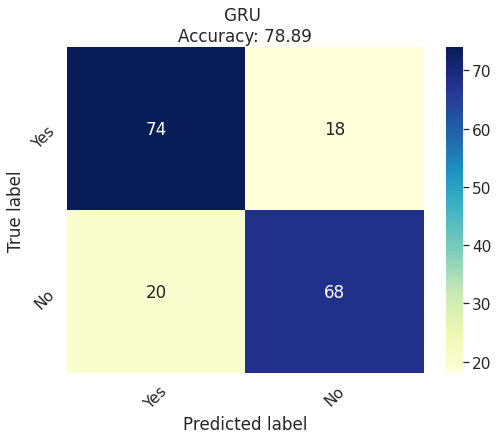

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
model = load_model(path+"Model.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['Yes' ,'No'], 
                     columns = ['Yes' ,'No'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('GRU \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [ ]:
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(testing_label_seq, y_pred)
precision=precision_score(testing_label_seq, y_pred)
recall=recall_score(testing_label_seq, y_pred)
f1=f1_score(testing_label_seq, y_pred)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))
print("precision: {:.2f}%".format(precision*100))
print("recall: {:.2f}%".format(recall*100))
print("f1: {:.2f}%".format(f1*100))

Accuracy: 78.89%
precision: 79.07%
recall: 77.27%
f1: 78.16%


In [ ]:
# report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
# report = report.rename(index={'0': 'Amusement','1':'IT','2':'International','3':'National','4':'Politics','5':'Sports'})
# report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
# report